# Лабораторная работа № 6.1

### Задача:

Используя явную схему крест и неявную схему, решить начально-краевую задачу для
дифференциального уравнения гиперболического типа. Аппроксимацию второго
начального условия произвести с первым и со вторым порядком. Осуществить
реализацию трех вариантов аппроксимации граничных условий, содержащих
производные: двухточечная аппроксимация с первым порядком, трехточечная
аппроксимация со вторым порядком, двухточечная аппроксимация со вторым
порядком. В различные моменты времени вычислить погрешность численного
решения путем сравнения результатов с приведенным в задании аналитическим
решением
$U(x,t)$
. Исследовать зависимость погрешности от сеточных параметров
$ \tau, h .$


In [1]:
import math, numpy as np, pandas as pd
import warnings
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
from matplotlib import cm
warnings.filterwarnings("ignore", category=DeprecationWarning) 

### Общий вид

$$ \frac{\partial^2 u}{\partial^2 t} + d\frac{\partial u}{\partial t} = 
a^2\frac{\partial^2 u}{\partial x^2} + b\frac{\partial u}{\partial x} + cu + f(x, t), a^2>0, b>0, c<0, d>0 $$

$$ \alpha_0 u_x(0, t) + \beta_0 u(0, t) = \phi_0(t) $$
$$ \alpha_l u_x(l, t) + \beta_l u(l, t) = \phi_l(t) $$
$$ u(x, 0) = \psi_1(x) $$
$$ u_t(x, 0) = \psi_2(x) $$

### Условие

$$ \frac{\partial^2 u}{\partial^2 t} = \frac{\partial^2 u}{\partial x^2} + \frac{\partial u}{\partial x} - u -cos(x)e^{-t} - 3\frac{\partial u}{\partial t} $$

$$ u_x(0, t) = e^{-t} $$
$$ u_x(\pi, t) = -e^{-t} $$
$$ u(x, 0) = sin(x) $$
$$ u_t(x, 0) = -sin(x) $$

### Аналитическое решение


$$ U(x,t) = e^{-t}sin(x) $$

### Численные методы

In [2]:
# Коэффициенты уравнения
a, b, c, d = 1.0, 1.0, -1.0, 3.0
# Длина и время
l = np.pi
T = 3.0
# Параметры численного решения
sigma = 0.25
n = 60

alpha0, betta0, alphal, bettal = 1.0, 0.0, 1.0, 0.0

def f(x, t):
    return -np.cos(x)*np.exp(-t)

def psi1(x):
    return np.sin(x)

def dpsi1(x):
    return np.cos(x)

def ddpsi1(x):
    return -np.sin(x)

def psi2(x):
    return -np.sin(x)

def phi0(t):
    return np.exp(-t)

def phil(t):
    return -np.exp(-t)

def decision(x, t):
    return np.exp(-t) * np.sin(x)

In [3]:
# Коэффициенты уравнения
a, b, c, d = 1.0, 2.0, -2.0, 0.0
# Длина и время
l = np.pi / 2.0
T = 3.0
# Параметры численного решения
sigma = 0.25
n = 40

alpha0, betta0, alphal, bettal = 0.0, 1.0, 0.0, 1.0

def f(x, t):
    return 0.0

def psi1(x):
    return np.exp(-x)*np.cos(x)

def dpsi1(x):
    return -np.exp(-x)*(np.cos(x) + np.sin(x))

def ddpsi1(x):
    return 2.0 * np.exp(-x) * np.sin(x)

def psi2(x):
    return 0.0

def phi0(t):
    return np.cos(2.0 * t)

def phil(t):
    return 0.0

def decision(x, t):
    return np.exp(-x) * np.cos(x) * np.cos(2.0*t)

Утилиты

In [4]:
class Scheme:
    def __init__(self, a, b, c, d, l, T, sigma, n, f, psi1, dpsi1, ddpsi1, psi2, phi0, phil, alpha0, betta0, alphal, bettal):
        
        self.a, self.b, self.c, self.l, self.T, self.sigma, self.n, self.f, self.psi1, self.phi0, self.phil, \
        self.alpha0, self.betta0, self.alphal, self.bettal = a, b, c, l, T, sigma, n, f, psi1, phi0, phil, \
        alpha0, betta0, alphal, bettal
        
        self.dpsi1 = dpsi1
        self.ddpsi1 = ddpsi1
        self.psi2 = psi2
        self.d = d
        
        self.h = l / n
        self.tau = (sigma * self.h) / (a**2)
        self.k = int(T / self.tau)
        self.result = [[0 for j in range(self.k + 1)] for i in range(self.n + 1)]
        
        print(self.n, self.k)
        
    def x_i(self, i):
        return self.h * i
    
    def t_k(self, k):
        return self.tau * k
    
    def _TMA(self, abc, d):
        if len(d) == 1:
            return [d[0] / abc[1][0]]
        dimension = len(d);
        result = [0 for i in range(dimension)]

        P = [0 for i in range(dimension)]
        Q = [0 for i in range(dimension)]
        P[0] = -(abc[2][0] / abc[1][0])
        Q[0] = (d[0] / abc[1][0])

        for i in range(1, dimension - 1):
            P[i] = -(abc[2][i] / (abc[1][i] + abc[0][i - 1] * P[i - 1]))
            Q[i] = ((d[i] - abc[0][i - 1] * Q[i - 1]) / (abc[1][i] + abc[0][i - 1] * P[i - 1]))


        result[dimension - 1] = ((d[dimension - 1] - abc[0][dimension - 2] * Q[dimension - 2])\
                                 / (abc[1][dimension - 1] + abc[0][dimension - 2] * P[dimension - 2]))

        for i in range(dimension - 1):
            k = dimension - 2 - i
            result[k] = P[k] * result[k + 1] + Q[k]

        return result
           
    def draw(self, rows):
        res = np.array(self.result).T.tolist()
        colums = 3
        all_count = colums * rows
        step = self.k // (all_count - 1)

        fig, ax = plt.subplots(rows, colums, figsize=(16, 4*rows), sharex='all', sharey='none')
        X = np.array([self.h*i for i in range(self.n+1)])

        for kk in range(0, all_count):

            TIME = np.array([self.tau*kk*step for i in range(self.n+1)])

            ax[kk // colums, kk % colums].plot(X, res[kk*step], '.-', X, decision(X, TIME))
            ax[kk // colums, kk % colums].set_title(f"{kk*step} (t = {self.tau*kk*step})")

        plt.show()
        
    def draw3D(self, decision = None, vmax = None):
        XX = np.array([self.x_i(i) for i in range(self.n + 1)])
        TT = np.array([self.t_k(j) for j in range(self.k + 1)])
        XX, TT = np.meshgrid(XX, TT)
        
        if decision != None:
            ZZ = decision(XX, TT)
            fig = plt.figure(figsize=(16,8))
            ax1 = fig.add_subplot(2, 4, 1, projection = "3d")
            ax2 = fig.add_subplot(2, 4, 2, projection = "3d")
            ax3 = fig.add_subplot(2, 4, (3,4))
            ax1.plot_surface(XX, TT, ZZ, cmap=cm.coolwarm, linewidth=0, antialiased=False)
            ax1.view_init(40, +30)

            ax2.plot_surface(XX, TT, np.array(self.result).T, cmap='viridis', linewidth=0, antialiased=False)
            ax2.view_init(40, +30)

            cf = ax3.contourf(XX, TT, np.abs(ZZ - np.array(self.result).T), 200, cmap=cm.coolwarm, vmax = vmax)
            fig.colorbar(cf)
        else:
            fig = plt.figure(figsize=(16,16))
            ax1 = fig.add_subplot(2, 4, (1,2), projection = "3d")
            ax2 = fig.add_subplot(2, 4, (3,4), projection = "3d")
            
            ax1.plot_surface(XX, TT, np.array(self.result).T, cmap='viridis', linewidth=0, antialiased=False)
            ax1.view_init(40, -30)
            
            ax2.plot_surface(XX, TT, np.array(self.result).T, cmap='viridis', linewidth=0, antialiased=False)
            ax2.view_init(40, +30)
        
        plt.show()
        
    def delta(self, decision = None):
        if decision == None: 
            return

        res = np.array(self.result).T.tolist()
        time, delt = [], []

        _, _ = plt.subplots(1, 1, figsize=(16, 4))

        X = np.array([self.h*_i for _i in range(self.n+1)])

        for i in range(self.k):
            TIME = np.array([self.tau*i for _i in range(self.n+1)])
            aaa = np.abs(res[i] - decision(X, TIME))

            time.append(self.tau*i)
            delt.append(np.max(aaa))

        plt.plot(time, delt)
        plt.show()

#### Явная схема

In [5]:
class ExplicitScheme(Scheme):
    
    def __init__(self, a, b, c, d, l, T, sigma, n, f, psi1, dpsi1, ddpsi1, psi2, phi0, phil, alpha0, betta0, alphal, bettal):
        super().__init__(a, b, c, d, l, T, sigma, n, f, psi1, dpsi1, ddpsi1, psi2, phi0, phil, alpha0, betta0, alphal, bettal)
    
    def solve(self, app_mode = 1, start_mode = 2):
        
        for i in range(self.n + 1):
            self.result[i][0] = self.psi1(self.x_i(i))
        
        if start_mode == 1:
            for i in range(self.n + 1):
                self.result[i][1] = self.result[i][0] + self.tau * self.psi2(self.x_i(i))
        else:
            for i in range(self.n + 1):
                self.result[i][1] = self.result[i][0] + self.tau * self.psi2(self.x_i(i)) + ((self.tau**2)/2.0) * \
                (self.a**2 * self.ddpsi1(self.x_i(i)) + self.b * self.dpsi1(self.x_i(i)) + c*self.psi1(self.x_i(i)) \
                 + self.f(self.x_i(i), self.t_k(1)) - self.d * self.psi2(self.x_i(i)))
        
        aa = (1.0 / self.tau**2) + (self.d / (2.0 * self.tau))
        bb = (self.a**2 / self.h**2) - (self.b / (2.0 * self.h))
        gg = (2.0 / self.tau**2) - (2.0 * self.a**2 / self.h**2) + self.c
        dd = (self.a**2 / self.h**2) + (self.b / (2.0 * self.h))
        ee = -(1.0 / self.tau**2) + (self.d / (2.0 * self.tau))

        for j in range(2, self.k + 1):
            for i in range(1, self.n):
                self.result[i][j] = (1/aa)*(bb * self.result[i-1][j-1] + gg * self.result[i][j-1] + dd * self.result[i+1][j-1] \
                                            + ee * self.result[i][j-2] + self.f(self.x_i(i), self.t_k(j-1)))

            if app_mode == 1:
                self.result[0][j] = (self.phi0(self.t_k(j)) - (self.alpha0 / self.h) * self.result[1][j]) \
                                    / (-self.alpha0 / self.h + self.betta0)

                self.result[self.n][j] = (self.phil(self.t_k(j)) + (self.alphal / self.h) * self.result[self.n-1][j]) \
                                / (self.alphal / self.h + self.bettal)
            elif app_mode == 2:
                self.result[0][j] = (self.phi0(self.t_k(j)) - (2 * self.alpha0 / self.h) * self.result[1][j] \
                                + (self.alpha0 / (2*self.h)) * self.result[2][j]) \
                                / (-3*self.alpha0 / (2*self.h) + self.betta0)

                self.result[self.n][j] = (self.phil(self.t_k(j)) + (2*self.alphal / self.h) * self.result[self.n-1][j] \
                                         - (self.alphal / (2*self.h)) * self.result[self.n-2][j]) \
                                    / (3*self.alphal / (2*self.h) + self.bettal)
            elif app_mode == 3:
                pp = self.h - (self.h**2 * self.b / (2.0 * self.a**2))
                f1 = (1/pp) * (-self.alpha0 - (self.h**2 * self.alpha0 / 2.0 / self.a**2 / self.tau**2) + \
                              (self.h**2 * self.alpha0 * self.c / 2.0 / self.a**2) - \
                              (self.h**2 * self.alpha0 * self.d / 4.0 / self.a**2 / self.tau) + self.betta0 * pp)
                f2 = (self.h**2 * self.alpha0 / 2.0 / self.a**2 / pp) * \
                     (((self.result[0][j-2] - 2.0 * self.result[0][j-1]) / self.tau**2) - self.f(self.x_i(0), self.t_k(j)) -\
                     (self.d * self.result[0][j-2] / 2.0 / self.tau))
                f3 = self.phi0(self.t_k(j)) - self.alpha0 * self.result[1][j] / pp
                
                self.result[0][j] = (f2 + f3) / f1
                
                pp = self.h + (self.h**2 * self.b / (2.0 * self.a**2))
                f1 = (1/pp) * (self.alphal + (self.h**2 * self.alphal / 2.0 / self.a**2 / self.tau**2) - \
                              (self.h**2 * self.alphal * self.c / 2.0 / self.a**2) + \
                              (self.h**2 * self.alphal * self.d / 4.0 / self.a**2 / self.tau) + self.bettal * pp)
                f2 = (self.h**2 * self.alphal / 2.0 / self.a**2 / pp) * \
                     (((self.result[self.n][j-2] - 2.0 * self.result[self.n][j-1]) / self.tau**2) - self.f(self.x_i(self.n), self.t_k(j)) -\
                     (self.d * self.result[self.n][j-2] / 2.0 / self.tau))
                f3 = self.phil(self.t_k(j)) + self.alphal * self.result[self.n-1][j] / pp
                
                self.result[self.n][j] = (f3 - f2) / f1
            
        return self.result

### 2Т1П

#### НУ1П

40 305


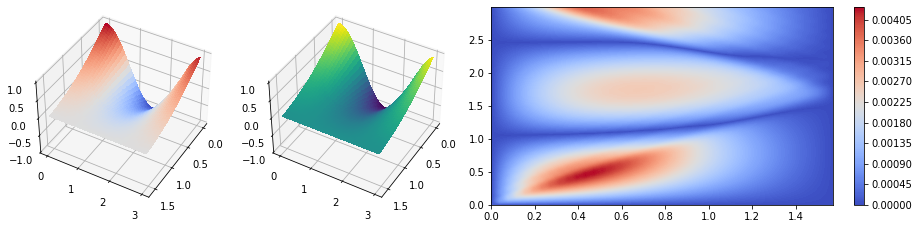

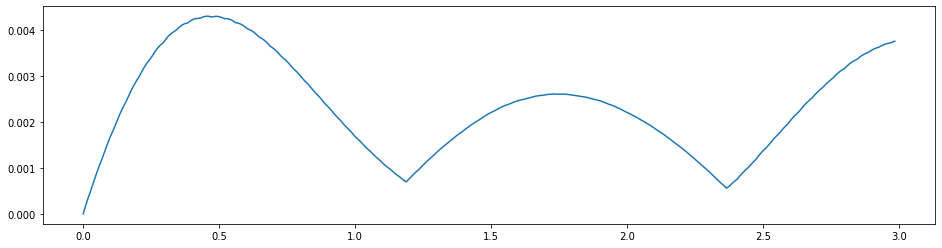

### 2Т1П

#### НУ2П

40 305


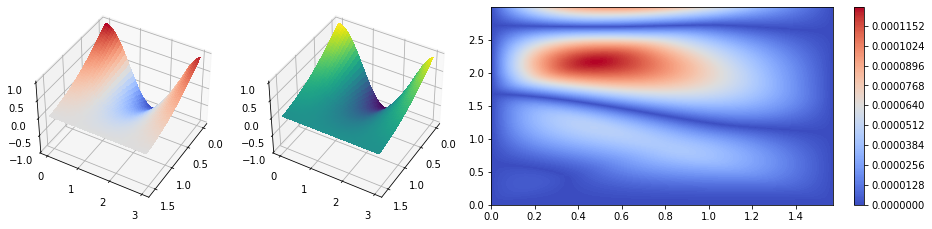

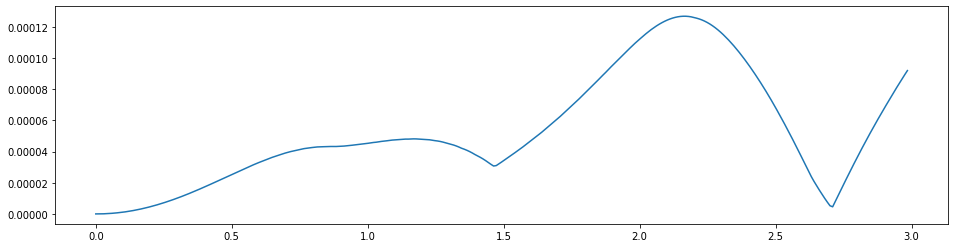

### 3Т2П

#### НУ1П

40 305


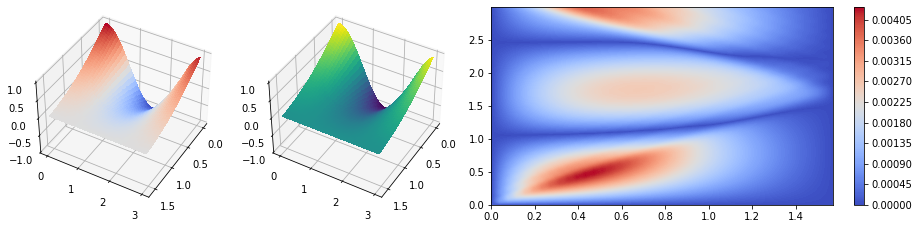

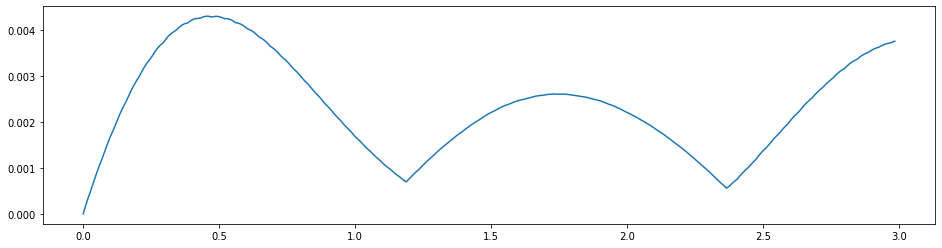

### 3Т2П

#### НУ2П

40 305


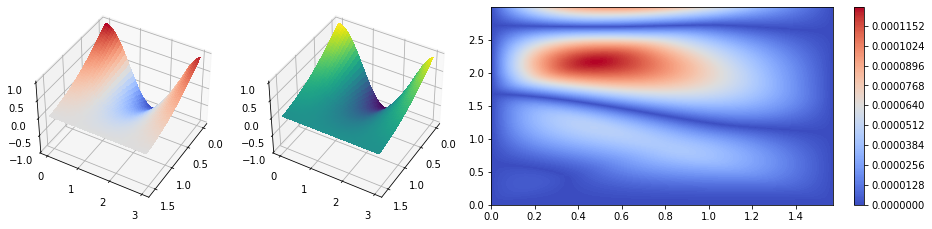

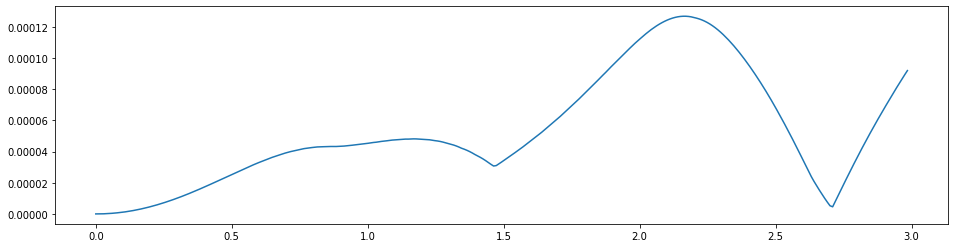

### 2Т2П

#### НУ1П

40 305


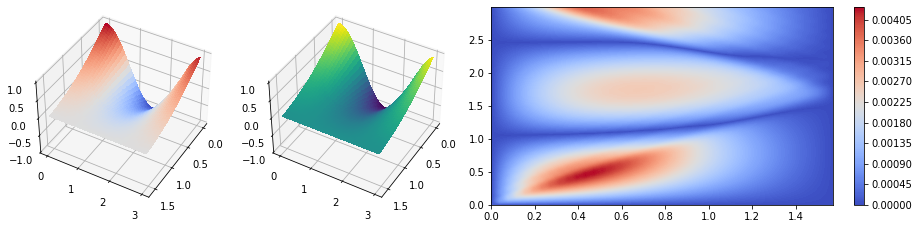

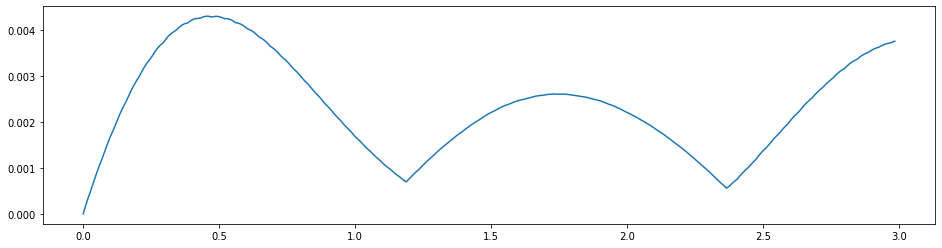

### 2Т2П

#### НУ2П

40 305


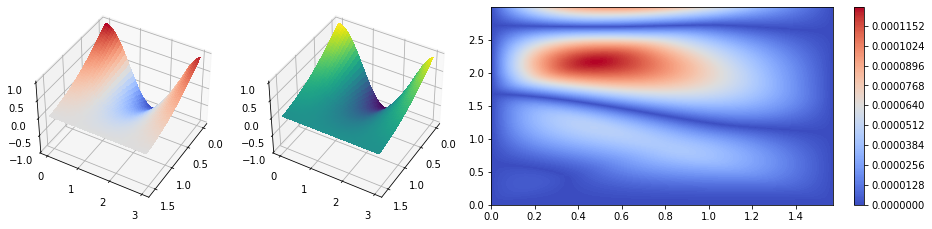

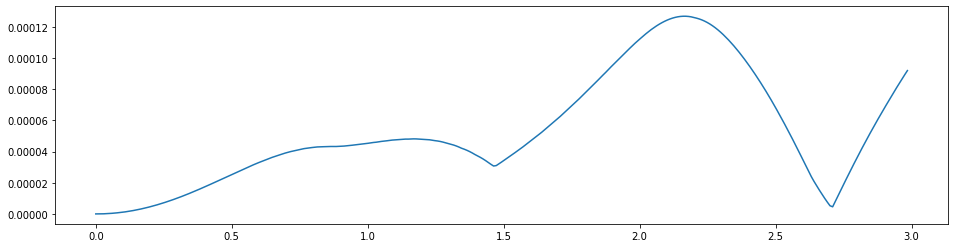

In [6]:
for i in [1,2,3]:
    for j in [1,2]:
        display(Markdown(["### 2Т1П", "### 3Т2П", "### 2Т2П"][i-1]))
        display(Markdown(["#### НУ1П", "#### НУ2П"][j-1]))
        ES = ExplicitScheme(a, b, c, d, l, T, sigma, n, f, psi1, dpsi1, ddpsi1, psi2, phi0, phil, alpha0, betta0, alphal, bettal)
        ES.solve(i, j)
        ES.draw3D(decision)
        ES.delta(decision)

#### Неявная схема

In [7]:
class ImplicitScheme(Scheme):
    
    def __init__(self, a, b, c, d, l, T, sigma, n, f, psi1, dpsi1, ddpsi1, psi2, phi0, phil, alpha0, betta0, alphal, betta):
        super().__init__(a, b, c, d, l, T, sigma, n, f, psi1, dpsi1, ddpsi1, psi2, phi0, phil, alpha0, betta0, alphal, betta)
    
    def solve(self, app_mode = 1, start_mode = 2):
        
        for i in range(self.n + 1):
            self.result[i][0] = self.psi1(self.x_i(i))
        
        if start_mode == 1:
            for i in range(self.n + 1):
                self.result[i][1] = self.result[i][0] + self.tau * self.psi2(self.x_i(i))
        else:
            for i in range(self.n + 1):
                self.result[i][1] = self.result[i][0] + self.tau * self.psi2(self.x_i(i)) + ((self.tau**2)/2.0) * \
                (self.a**2 * self.ddpsi1(self.x_i(i)) + self.b * self.dpsi1(self.x_i(i)) + c*self.psi1(self.x_i(i)) \
                 + self.f(self.x_i(i), self.t_k(1)) - self.d * self.psi2(self.x_i(i)))

        aa = (self.b / (2 * self.h)) - (self.a**2 / (self.h**2))
        bb = (1/(self.tau**2)) + (2*self.a**2 / (self.h**2)) - self.c + (self.d / 2.0 / self.tau)
        gg = -(self.b / (2 * self.h)) - (self.a**2 / (self.h**2))
        
        x = self.alpha0 / (2 * self.h * gg)
        y = - self.alphal / (2 * self.h * aa)
        
        
        abc = [[0]*self.n, [0] * (self.n + 1), [0]*self.n]
        d = [0] * (self.n + 1)
        
        for j in range(2, self.k + 1):

            if app_mode == 1:
                for i in range(self.n + 1):
                    if i == 0:
                        d[i] = self.phi0(self.t_k(j))
                    elif i == n: 
                        d[i] = self.phil(self.t_k(j))
                    else: 
                        d[i] = self.f(self.x_i(i), self.t_k(j)) + (self.d / 2.0 / self.tau) * self.result[i][j-2] - \
                               ((self.result[i][j-2] - 2.0 * self.result[i][j-1]) / self.tau**2)
                        
                    if i == 0:
                        abc[1][i] = self.betta0 - self.alpha0 / self.h
                        abc[2][i] = self.alpha0 / self.h
                    elif i == n:
                        abc[0][i-1] = - self.alphal / self.h
                        abc[1][i] = self.alphal / self.h + self.bettal
                    else:
                        abc[0][i-1] = aa
                        abc[1][i] = bb
                        abc[2][i] = gg
                        
                r = self._TMA(abc, d)
                
                for i in range(self.n + 1):
                    self.result[i][j] = r[i]
                    
            elif app_mode == 2:
                for i in range(self.n + 1):
                    if i == 0:
                        d[1] = self.f(self.x_i(1), self.t_k(j)) + (self.d / 2.0 / self.tau) * self.result[1][j-2] - \
                               ((self.result[1][j-2] - 2.0 * self.result[1][j-1]) / self.tau**2)
                        d[i] = self.phi0(self.t_k(j)) + d[1] * x
                    elif i == n: 
                        d[i] = self.phil(self.t_k(j)) + d[n-1] * y
                    else: 
                        d[i] = self.f(self.x_i(i), self.t_k(j)) + (self.d / 2.0 / self.tau) * self.result[i][j-2] - \
                               ((self.result[i][j-2] - 2.0 * self.result[i][j-1]) / self.tau**2)
                        
                    if i == 0:
                        abc[1][i] = self.betta0 - 3 * self.alpha0 / (2 * self.h) + aa * x
                        abc[2][i] = 2 * self.alpha0 / self.h + bb * x
                    elif i == n:
                        abc[0][i-1] = - 2 * self.alphal / self.h + bb * y
                        abc[1][i] = 3 * self.alphal / (2 * self.h) + self.bettal + gg * y
                    else:
                        abc[0][i-1] = aa
                        abc[1][i] = bb
                        abc[2][i] = gg
                        
                r = self._TMA(abc, d)
                
                for i in range(self.n + 1):
                    self.result[i][j] = r[i]
                    
            elif app_mode == 3:
                pp1 = self.h - (self.h**2 * self.b / 2.0 / self.a**2)
                pp2 = self.h + (self.h**2 * self.b / 2.0 / self.a**2)
                for i in range(self.n + 1):
                    if i == 0:
                        d[i] = (2.0 * self.a**2 * pp1 * self.phi0(self.t_k(j))) + \
                               (self.h**2 * self.alpha0) * \
                               ((self.result[0][j-2] - 2*self.result[0][j-1]) / self.tau**2 - self.f(self.x_i(0), self.t_k(j)) -\
                               (self.d * self.result[0][j-2] / 2.0 / self.tau))
                    elif i == n: 
                        d[i] = (2.0 * self.a**2 * pp2 * self.phil(self.t_k(j))) - \
                               (self.h**2 * self.alphal) * \
                               ((self.result[self.n][j-2] - 2*self.result[self.n][j-1]) / self.tau**2 - \
                                self.f(self.x_i(self.n), self.t_k(j)) - \
                               (self.d * self.result[self.n][j-2] / 2.0 / self.tau))
                    else: 
                        d[i] = self.f(self.x_i(i), self.t_k(j)) + (self.d / 2.0 / self.tau) * self.result[i][j-2] - \
                               ((self.result[i][j-2] - 2.0 * self.result[i][j-1]) / self.tau**2)
                        
                    if i == 0:
                        abc[1][i] = (-2*self.a**2*self.alpha0) - (self.h**2 * self.alpha0 / (self.tau**2)) + \
                                    (self.h**2 * self.alpha0 * self.c) + (2 * self.a**2 * self.betta0 * pp1) - \
                                    (self.h**2 * self.alpha0 * self.d / 2.0 / self.tau)
                        abc[2][i] = 2 * self.a**2 * self.alpha0
                    elif i == n:
                        abc[0][i-1] = -2 * self.a**2 * self.alphal
                        abc[1][i] = (2*self.a**2*self.alphal) + (self.h**2 * self.alphal / (self.tau**2)) - \
                                    (self.h**2 * self.alphal * self.c) + (2 * self.a**2 * self.bettal * pp2) + \
                                    (self.h**2 * self.alphal * self.d / 2.0 / self.tau)
                    else:
                        abc[0][i-1] = aa
                        abc[1][i] = bb
                        abc[2][i] = gg
                        
                r = self._TMA(abc, d)
                
                for i in range(self.n + 1):
                    self.result[i][j] = r[i]
            
        return self.result

### 2Т1П

#### НУ1П

40 305


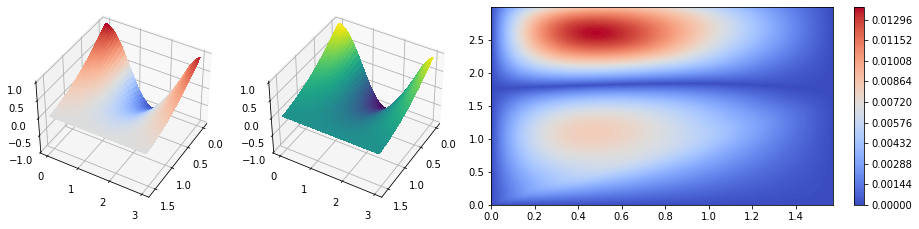

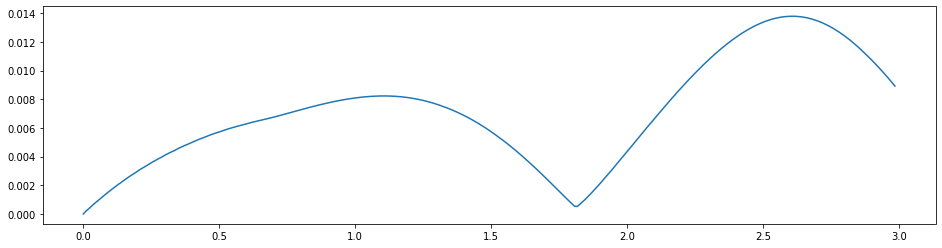

### 2Т1П

#### НУ2П

40 305


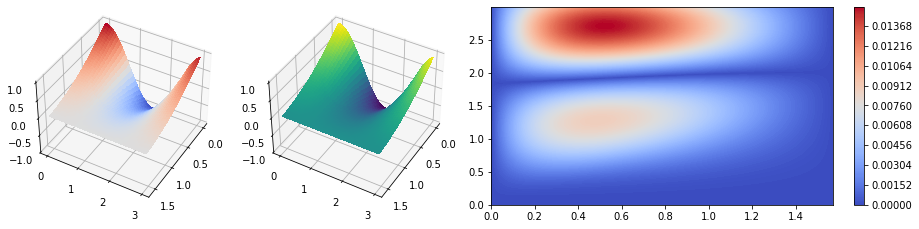

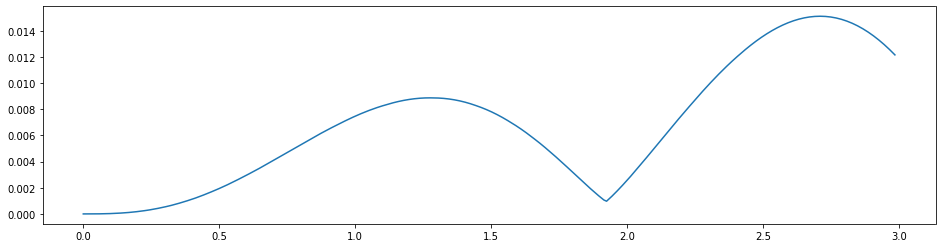

### 3Т2П

#### НУ1П

40 305


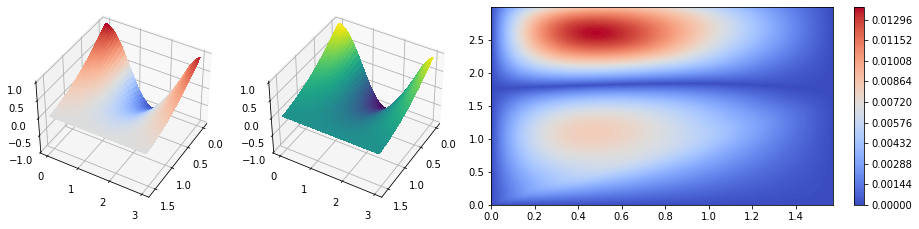

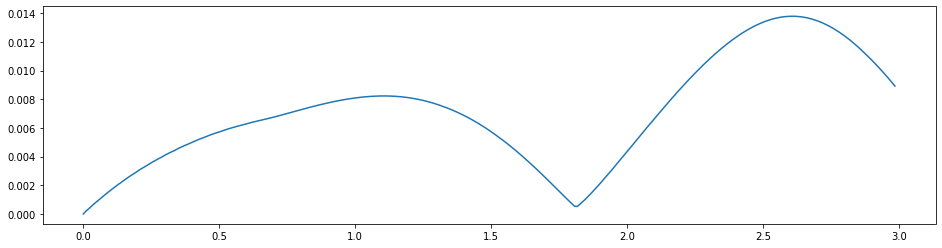

### 3Т2П

#### НУ2П

40 305


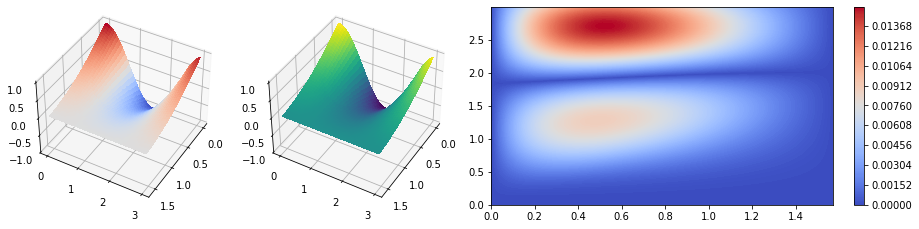

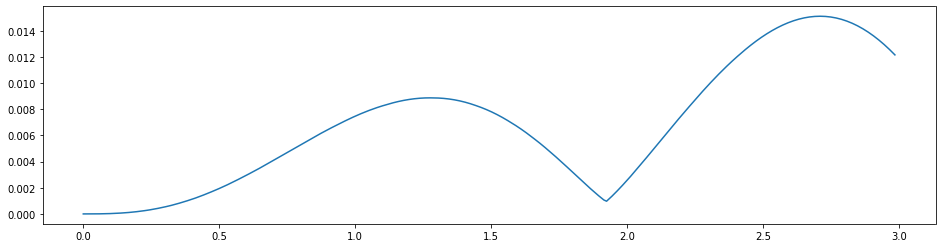

### 2Т2П

#### НУ1П

40 305


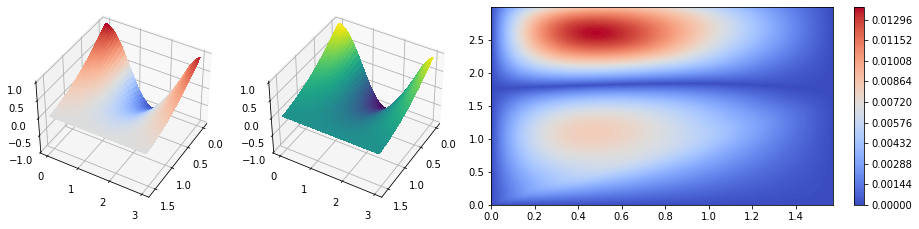

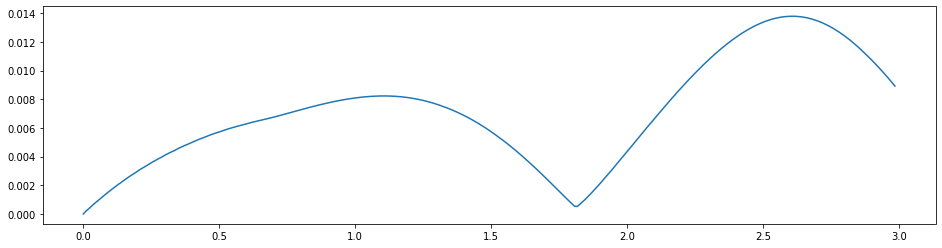

### 2Т2П

#### НУ2П

40 305


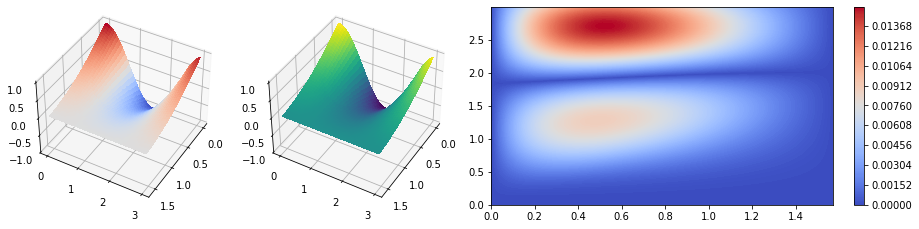

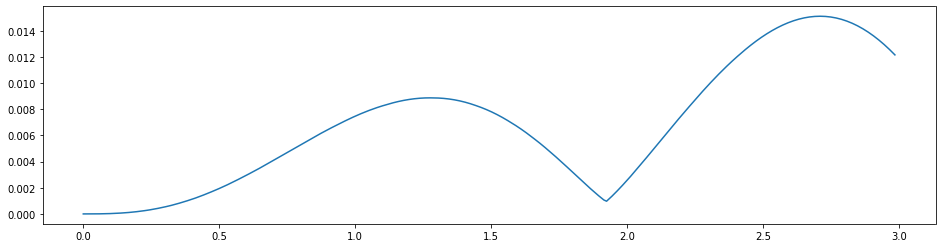

In [8]:
for i in [1,2,3]:
    for j in [1,2]:
        display(Markdown(["### 2Т1П", "### 3Т2П", "### 2Т2П"][i-1]))
        display(Markdown(["#### НУ1П", "#### НУ2П"][j-1]))
        ES = ImplicitScheme(a, b, c, d, l, T, sigma, n, f, psi1, dpsi1, ddpsi1, psi2, phi0, phil, alpha0, betta0, alphal, bettal)
        ES.solve(i, j)
        ES.draw3D(decision)
        ES.delta(decision)